In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

import backtrader as bt
import backtrader.analyzers as btanalyzers
import pandas as pd
import numpy as np
import pickle

In [3]:
def moving_average(x, w):
        moving_avg = np.convolve(x, np.ones(w), 'valid') / w
        padding = np.full_like(np.empty(w), np.nan)
        return np.insert(moving_avg, 0, padding)

def moving_avg_diff(short, long):
        return (short - long) / long


def get_X_y(df, binary_output=True):
    
    min_period = 30
    
    percent_change = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1)
    print(percent_change[:5])

    y = percent_change.copy()
    
    print(len(y))
    
    ## TEMP
    if binary_output == True:
        y = np.zeros(percent_change.shape)
        y[np.where(percent_change > 0)] = 1
    else:
        y = y.to_numpy()
    
    moving_average_1_day = moving_average(df["Close"], 1)
    moving_average_2_day = moving_average(df["Close"], 2)
    moving_average_3_day = moving_average(df["Close"], 3)
    moving_average_4_day = moving_average(df["Close"], 4)
    moving_average_5_day = moving_average(df["Close"], 5)
    moving_average_6_day = moving_average(df["Close"], 6)
    moving_average_7_day = moving_average(df["Close"], 7)
    moving_average_14_day = moving_average(df["Close"], 14)
    moving_average_30_day = moving_average(df["Close"], 30)
    
    mv_1d_2d = moving_avg_diff(moving_average_1_day, moving_average_2_day)
    mv_1d_3d = moving_avg_diff(moving_average_1_day, moving_average_3_day)
    mv_2d_4d = moving_avg_diff(moving_average_1_day, moving_average_3_day)
    mv_3d_7d = moving_avg_diff(moving_average_3_day, moving_average_7_day)
    mv_7d_14d = moving_avg_diff(moving_average_7_day, moving_average_14_day)
    mv_7d_30d = moving_avg_diff(moving_average_7_day, moving_average_30_day)
        
    X = np.stack((mv_1d_2d, mv_1d_3d, mv_3d_7d, mv_7d_14d, mv_7d_30d), axis=1)
    X = X[min_period:len(X)-1]
    y = y[min_period:]
    
    print(len(X), len(y))
    
    return (X, y)

In [4]:
df = pd.read_csv("../../data/clean/bitcoin_prices.csv")
df = df.iloc[::24, :]

df["Time"] = pd.to_datetime(df['Time'],unit='s')
df.set_index(pd.DatetimeIndex(df['Time']), inplace=True, drop=True)
start_date = datetime.datetime(2015,7,1)
df = df[df["Time"] > start_date]

offset = 30 # TODO: Refactor to output ox get_features
X, y = get_X_y(df)
df = df[offset:]
for i in range(0, len(X[0,:])):
    df["X_" + str(i)] = X[:,i]
df.describe()
print(df.columns)

Time
2015-07-20 21:00:00         NaN
2015-07-21 21:00:00    0.006691
2015-07-22 21:00:00   -0.009862
2015-07-23 21:00:00   -0.001444
2015-07-24 21:00:00    0.045501
Name: Close, dtype: float64
1988
1958 1958
Index(['Unnamed: 0', 'Time', 'Low', 'High', 'Open', 'Close', 'Volume', 'X_0',
       'X_1', 'X_2', 'X_3', 'X_4'],
      dtype='object')


In [5]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [6]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    data = bt.feeds.PandasData(dataname=df)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


In [13]:
# Create a Stratey
class NNStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.X_0 = self.datas[0].X_0
        self.X_1 = self.datas[0].X_1
        self.X_2 = self.datas[0].X_2
        self.X_3 = self.datas[0].X_3
        self.X_4 = self.datas[0].X_4

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        filename = "../../models/pickles/neural_net_v2_daily_price"
        self.clf = pickle.load(open(filename, 'rb'))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
    
        X = [[self.X_0[0], self.X_1[0], self.X_2[0], self.X_3[0], self.X_4[0]]]
        pred = self.clf.predict(X)[0]
        print(pred)
        if not self.position:
            if pred == 1:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                
                # Cancel existing orders 
                self.broker.cancel(self.order)
                
                cash = self.broker.get_cash()
                limit_price = self.data.close[0] * 1.05
                size = cash * 0.95 / limit_price
                print(cash, self.data.close[0], limit_price, size)
                
                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
                self.buy(exectype=bt.Order.Limit, size=size)
        elif self.position and pred == 0:
            
            ## TODO: figure out why it never sells all it's position
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            size = self.broker.get_value() / self.dataclose[0]
            self.sell(size=self.position.size)


class PandasData(bt.feeds.PandasData):
    params = (
        ('X_0', 'X_0'),
        ('X_1', 'X_1'),
        ('X_2', 'X_2'),
        ('X_3', 'X_3'),
        ('X_4', 'X_4'),
    )
    lines = ('X_0','X_1', 'X_2', 'X_3', 'X_4')

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(NNStrategy)

    data = PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)

    cerebro.addsizer(bt.sizers.FixedSize, stake=1)

    cerebro.broker.addcommissioninfo(CommInfoFractional())
    
    ## Include commission to see algo's returns with Coinbase Fees
    cerebro.broker.setcommission(commission=0.005, margin=False) 
    
    cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='annualreturn')
    cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(btanalyzers.Returns, _name='returns')
    cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='tradeanalyzer')

    cerebro.addobserver(bt.observers.DrawDown)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    strats = cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2015-08-19, Close, 225.64
1.0
2015-08-19, BUY CREATE, 225.64
10000.0 225.64 236.922 40.09758485915196
2015-08-20, BUY EXECUTED, Price: 236.72, Cost: 236.72, Comm 1.18
2015-08-20, Close, 236.68
1.0
2015-08-21, Close, 233.30
0.0
2015-08-21, SELL CREATE, 233.30
2015-08-22, SELL EXECUTED, Price: 228.10, Cost: 236.72, Comm 1.14
2015-08-22, OPERATION PROFIT, GROSS -8.62, NET -10.94
2015-08-22, Close, 230.69
0.0
2015-08-23, Close, 228.16
1.0
2015-08-23, BUY CREATE, 228.16
9989.055900000001 228.16 239.568 39.61131330144259
2015-08-24, BUY EXECUTED, Price: 215.54, Cost: 8642.63, Comm 43.21
2015-08-24, BUY EXECUTED, Price: 215.54, Cost: 215.54, Comm 1.08
2015-08-24, Order Canceled/Margin/Rejected
2015-08-24, Close, 210.48
1.0
2015-08-25, Close, 223.55
1.0
2015-08-26, Close, 227.58
0.0
2015-08-26, SELL CREATE, 227.58
2015-08-27, SELL EXECUTED, Price: 227.41, Cost: 8858.17, Comm 46.73
2015-08-27, OPERATION PROFIT, GROSS 487.83, NET 396.81
2015-08-27, Close, 227.2

2016-05-02, Close, 446.81
1.0
2016-05-03, Close, 452.11
1.0
2016-05-04, Close, 448.21
1.0
2016-05-05, Close, 450.16
1.0
2016-05-06, Close, 460.66
1.0
2016-05-07, Close, 462.20
1.0
2016-05-08, Close, 461.30
1.0
2016-05-09, Close, 461.68
1.0
2016-05-10, Close, 454.53
1.0
2016-05-11, Close, 453.11
1.0
2016-05-12, Close, 453.78
1.0
2016-05-13, Close, 457.57
1.0
2016-05-14, Close, 459.33
1.0
2016-05-15, Close, 462.67
1.0
2016-05-16, Close, 456.24
1.0
2016-05-17, Close, 454.60
1.0
2016-05-18, Close, 456.34
1.0
2016-05-19, Close, 444.30
1.0
2016-05-20, Close, 443.43
1.0
2016-05-21, Close, 446.22
1.0
2016-05-22, Close, 443.30
0.0
2016-05-22, SELL CREATE, 443.30
2016-05-23, SELL EXECUTED, Price: 444.49, Cost: 8431.33, Comm 44.66
2016-05-23, OPERATION PROFIT, GROSS 501.20, NET 414.38
2016-05-23, Close, 444.78
0.0
2016-05-24, Close, 447.50
0.0
2016-05-25, Close, 450.88
0.0
2016-05-26, Close, 454.96
0.0
2016-05-27, Close, 471.00
0.0
2016-05-28, Close, 519.46
0.0
2016-05-29, Close, 527.25
0.0
2016-

2016-10-07, BUY CREATE, 618.09
10971.602890553339 618.09 648.9945 16.060263601657134
2016-10-08, BUY EXECUTED, Price: 618.89, Cost: 618.89, Comm 3.09
2016-10-08, Close, 619.17
0.0
2016-10-08, SELL CREATE, 619.17
2016-10-09, BUY EXECUTED, Price: 618.09, Cost: 9926.69, Comm 49.63
2016-10-09, SELL EXECUTED, Price: 618.65, Cost: 618.14, Comm 3.09
2016-10-09, Close, 617.81
1.0
2016-10-10, Close, 618.26
1.0
2016-10-11, Close, 639.50
1.0
2016-10-12, Close, 635.56
0.0
2016-10-12, SELL CREATE, 635.56
2016-10-13, SELL EXECUTED, Price: 635.81, Cost: 9927.44, Comm 51.06
2016-10-13, OPERATION PROFIT, GROSS 284.35, NET 177.47
2016-10-13, Close, 636.79
1.0
2016-10-13, BUY CREATE, 636.79
11149.073238924113 636.79 668.6295 15.840790119158527
2016-10-14, BUY EXECUTED, Price: 638.20, Cost: 638.20, Comm 3.19
2016-10-14, Close, 637.93
1.0
2016-10-15, BUY EXECUTED, Price: 636.79, Cost: 10087.26, Comm 50.44
2016-10-15, Close, 636.52
1.0
2016-10-16, Close, 643.63
1.0
2016-10-17, Close, 637.32
1.0
2016-10-18, 

1.0
2017-05-03, Close, 1513.00
1.0
2017-05-04, Close, 1544.71
1.0
2017-05-05, Close, 1560.10
1.0
2017-05-06, Close, 1585.87
1.0
2017-05-07, Close, 1599.20
1.0
2017-05-08, Close, 1664.94
1.0
2017-05-09, Close, 1716.74
1.0
2017-05-10, Close, 1782.00
1.0
2017-05-11, Close, 1833.98
1.0
2017-05-12, Close, 1716.76
1.0
2017-05-13, Close, 1774.79
1.0
2017-05-14, Close, 1798.99
1.0
2017-05-15, Close, 1743.99
1.0
2017-05-16, Close, 1759.74
1.0
2017-05-17, Close, 1800.55
1.0
2017-05-18, Close, 1880.01
1.0
2017-05-19, Close, 1971.48
1.0
2017-05-20, Close, 2046.94
1.0
2017-05-21, Close, 2046.80
1.0
2017-05-22, Close, 2141.17
1.0
2017-05-23, Close, 2244.39
1.0
2017-05-24, Close, 2465.01
1.0
2017-05-25, Close, 2567.70
1.0
2017-05-26, Close, 2285.19
1.0
2017-05-27, Close, 2051.90
0.0
2017-05-27, SELL CREATE, 2051.90
2017-05-28, SELL EXECUTED, Price: 2180.88, Cost: 16535.51, Comm 153.89
2017-05-28, OPERATION PROFIT, GROSS 14241.91, NET 14005.35
2017-05-28, Close, 2222.00
0.0
2017-05-29, Close, 2322.94


0.0
2017-12-27, SELL CREATE, 15196.19
2017-12-28, SELL EXECUTED, Price: 13926.36, Cost: 14071.01, Comm 69.63
2017-12-28, OPERATION PROFIT, GROSS -144.65, NET -284.64
2017-12-28, Close, 13947.96
1.0
2017-12-28, BUY CREATE, 13947.96
101347.61734993063 13947.96 14645.358 6.574112867874865
2017-12-29, Order Canceled/Margin/Rejected
2017-12-29, BUY EXECUTED, Price: 14441.00, Cost: 14441.00, Comm 72.20
2017-12-29, Close, 14389.99
1.0
2017-12-30, Close, 13213.99
1.0
2017-12-31, Close, 14067.00
1.0
2018-01-01, Close, 13565.00
0.0
2018-01-01, SELL CREATE, 13565.00
2018-01-02, SELL EXECUTED, Price: 14830.00, Cost: 14441.00, Comm 74.15
2018-01-02, OPERATION PROFIT, GROSS 389.00, NET 242.64
2018-01-02, Close, 14761.01
0.0
2018-01-03, Close, 15067.99
0.0
2018-01-04, Close, 14940.04
0.0
2018-01-05, Close, 16727.02
1.0
2018-01-05, BUY CREATE, 16727.02
101590.26234993064 16727.02 17563.371000000003 5.495001456863497
2018-01-06, Order Canceled/Margin/Rejected
2018-01-06, BUY EXECUTED, Price: 16849.50, 

0.0
2018-07-01, SELL CREATE, 6360.00
2018-07-02, SELL EXECUTED, Price: 6618.99, Cost: 81247.55, Comm 455.32
2018-07-02, OPERATION PROFIT, GROSS 9817.39, NET 8955.83
2018-07-02, Close, 6647.01
0.0
2018-07-03, Close, 6605.00
0.0
2018-07-04, Close, 6689.93
1.0
2018-07-04, BUY CREATE, 6689.93
92468.28729094719 6689.93 7024.4265000000005 12.505629167932758
2018-07-05, BUY EXECUTED, Price: 6504.61, Cost: 6504.61, Comm 32.52
2018-07-05, BUY EXECUTED, Price: 6504.61, Cost: 81344.24, Comm 406.72
2018-07-05, Close, 6488.31
1.0
2018-07-06, Close, 6588.19
1.0
2018-07-07, Close, 6528.10
0.0
2018-07-07, SELL CREATE, 6528.10
2018-07-08, SELL EXECUTED, Price: 6744.74, Cost: 87848.85, Comm 455.46
2018-07-08, OPERATION PROFIT, GROSS 3243.11, NET 2348.40
2018-07-08, Close, 6748.09
0.0
2018-07-09, Close, 6712.18
0.0
2018-07-10, Close, 6378.20
1.0
2018-07-10, BUY CREATE, 6378.20
94816.68998396213 6378.2 6697.11 13.449959084554983
2018-07-11, BUY EXECUTED, Price: 6352.78, Cost: 6352.78, Comm 31.76
2018-07-1

0.0
2018-11-23, SELL CREATE, 4256.13
2018-11-24, SELL EXECUTED, Price: 4139.67, Cost: 56099.22, Comm 274.57
2018-11-24, OPERATION PROFIT, GROSS -1198.20, NET -1795.49
2018-11-24, Close, 3803.62
1.0
2018-11-24, BUY CREATE, 3803.62
61756.27210547776 3803.62 3993.801 14.689880266994741
2018-11-25, BUY EXECUTED, Price: 3927.51, Cost: 3927.51, Comm 19.64
2018-11-25, Close, 4048.00
1.0
2018-11-26, BUY EXECUTED, Price: 3632.29, Cost: 53357.91, Comm 266.79
2018-11-26, Close, 3661.54
0.0
2018-11-26, SELL CREATE, 3661.54
2018-11-27, SELL EXECUTED, Price: 3729.64, Cost: 57285.42, Comm 292.59
2018-11-27, OPERATION PROFIT, GROSS 1232.19, NET 653.17
2018-11-27, Close, 3765.84
1.0
2018-11-27, BUY CREATE, 3765.84
62409.4468482997 3765.84 3954.1320000000005 14.994181910438172
2018-11-28, BUY EXECUTED, Price: 4318.00, Cost: 4318.00, Comm 21.59
2018-11-28, Close, 4220.00
1.0
2018-11-29, Close, 4181.56
0.0
2018-11-29, SELL CREATE, 4181.56
2018-11-30, SELL EXECUTED, Price: 3957.83, Cost: 4318.00, Comm 19.7

2019-05-30, Close, 8209.98
1.0
2019-05-31, Close, 8528.15
1.0
2019-06-01, Close, 8597.86
1.0
2019-06-02, Close, 8715.00
1.0
2019-06-03, Close, 8484.00
1.0
2019-06-04, Close, 7437.76
1.0
2019-06-05, Close, 7736.94
1.0
2019-06-06, Close, 7738.94
1.0
2019-06-07, Close, 7954.10
1.0
2019-06-08, Close, 7893.81
1.0
2019-06-09, Close, 7636.34
1.0
2019-06-10, Close, 7950.58
1.0
2019-06-11, Close, 7912.06
1.0
2019-06-12, Close, 8154.99
1.0
2019-06-13, Close, 8316.80
0.0
2019-06-13, SELL CREATE, 8316.80
2019-06-14, SELL EXECUTED, Price: 8454.15, Cost: 108020.37, Comm 583.38
2019-06-14, OPERATION PROFIT, GROSS 8655.14, NET 7531.66
2019-06-14, Close, 8623.78
0.0
2019-06-15, Close, 8825.05
0.0
2019-06-16, Close, 9037.07
0.0
2019-06-17, Close, 9291.06
1.0
2019-06-17, BUY CREATE, 9291.06
120742.01484490807 9291.06 9755.613 11.757837677925792
2019-06-18, BUY EXECUTED, Price: 9126.22, Cost: 9126.22, Comm 45.63
2019-06-18, BUY EXECUTED, Price: 9126.22, Cost: 107304.61, Comm 536.52
2019-06-18, Close, 9022

2020-02-22, Close, 9695.84
1.0
2020-02-23, Close, 9885.01
1.0
2020-02-24, Close, 9605.42
1.0
2020-02-25, Close, 9378.02
1.0
2020-02-26, Close, 8742.41
1.0
2020-02-27, Close, 8755.43
1.0
2020-02-28, Close, 8667.24
1.0
2020-02-29, Close, 8634.27
0.0
2020-02-29, SELL CREATE, 8634.27
2020-03-01, SELL EXECUTED, Price: 8481.25, Cost: 8074.48, Comm 42.41
2020-03-01, OPERATION PROFIT, GROSS 406.77, NET 323.99
2020-03-01, Close, 8514.82
0.0
2020-03-02, Close, 8944.30
1.0
2020-03-02, BUY CREATE, 8944.30
75823.04606503082 8944.3 9391.515 7.6698907217610035
2020-03-03, Order Canceled/Margin/Rejected
2020-03-03, BUY EXECUTED, Price: 8707.77, Cost: 8707.77, Comm 43.54
2020-03-03, Close, 8736.37
0.0
2020-03-03, SELL CREATE, 8736.37
2020-03-04, SELL EXECUTED, Price: 8709.00, Cost: 8707.77, Comm 43.55
2020-03-04, OPERATION PROFIT, GROSS 1.23, NET -85.85
2020-03-04, Close, 8733.49
1.0
2020-03-04, BUY CREATE, 8733.49
75737.19221503082 8733.49 9170.1645 7.846133251402335
2020-03-05, Order Canceled/Margin/

0.0
2020-09-02, SELL CREATE, 11389.42
2020-09-03, SELL EXECUTED, Price: 10783.28, Cost: 11374.00, Comm 53.92
2020-09-03, OPERATION PROFIT, GROSS -590.72, NET -701.51
2020-09-03, Close, 10733.64
1.0
2020-09-03, BUY CREATE, 10733.64
92462.93251997905 10733.64 11270.322 7.79390206366598
2020-09-04, Order Canceled/Margin/Rejected
2020-09-04, BUY EXECUTED, Price: 10604.96, Cost: 10604.96, Comm 53.02
2020-09-04, Close, 10558.79
1.0
2020-09-05, Close, 10087.82
1.0
2020-09-06, Close, 10324.12
1.0
2020-09-07, Close, 10156.73
0.0
2020-09-07, SELL CREATE, 10156.73
2020-09-08, SELL EXECUTED, Price: 10014.97, Cost: 10604.96, Comm 50.07
2020-09-08, OPERATION PROFIT, GROSS -589.99, NET -693.09
2020-09-08, Close, 10030.96
0.0
2020-09-09, Close, 10243.00
1.0
2020-09-09, BUY CREATE, 10243.00
91769.84286997905 10243.0 10755.15 8.106009746631159
2020-09-10, Order Canceled/Margin/Rejected
2020-09-10, BUY EXECUTED, Price: 10300.01, Cost: 10300.01, Comm 51.50
2020-09-10, Close, 10348.55
0.0
2020-09-10, SELL 

In [14]:
print('Returns:', strats[0].analyzers.returns.pprint())
print('Sharpe Ratio:', strats[0].analyzers.mysharpe.pprint())
print('Annual Return:', strats[0].analyzers.annualreturn.pprint())
print('Drawdown:', strats[0].analyzers.drawdown.pprint())
print('Trade Analyzer:', strats[0].analyzers.tradeanalyzer.pprint())

OrderedDict([('rtot', 2.3572892011770117),
             ('ravg', 0.0012039270690383103),
             ('rnorm', 0.3544420812669563),
             ('rnorm100', 35.44420812669563)])
Returns: None
OrderedDict([('sharperatio', 0.5255999430001832)])
Sharpe Ratio: None
OrderedDict([(2015, 0.1927440354526042),
             (2016, 0.3987912681655559),
             (2017, 5.047795244594692),
             (2018, -0.37417887534527927),
             (2019, 0.19825378010823003),
             (2020, 0.39592286389211595)])
Annual Return: None
AutoOrderedDict([('len', 537),
                 ('drawdown', 35.596402778289786),
                 ('moneydown', 58378.600467995115),
                 ('max',
                  AutoOrderedDict([('len', 537),
                                   ('drawdown', 61.01814713228409),
                                   ('moneydown', 100070.61822846632)]))])
Drawdown: None
AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 210),
                       

<IPython.core.display.Javascript object>


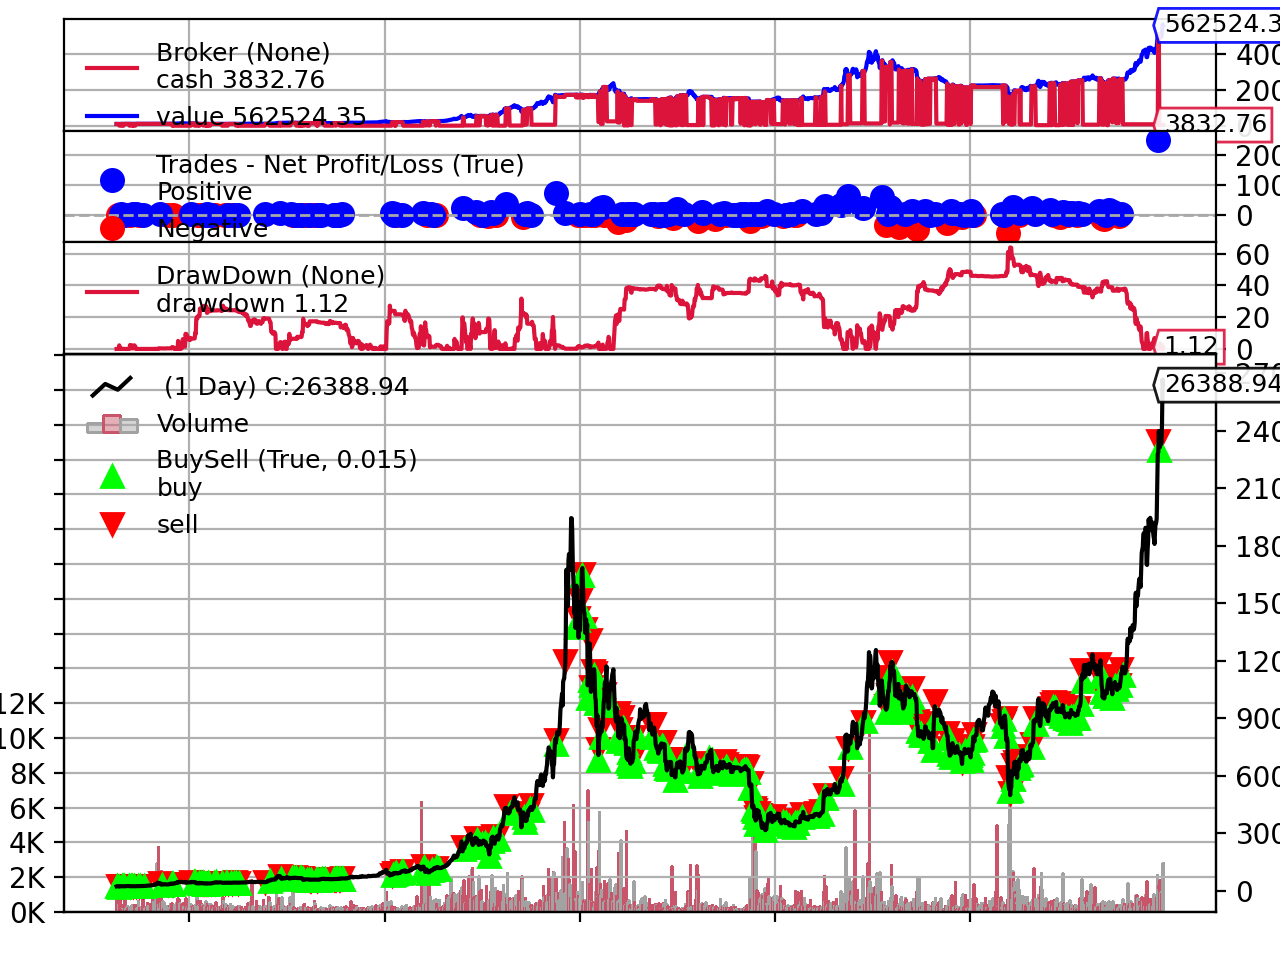

[[<Figure size 640x480 with 5 Axes>]]

In [11]:
cerebro.plot()